Ramen rating data from Kaggle: https://www.kaggle.com/residentmario/ramen-ratings

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def cles_ind(x1, x2):
    """Calc common language effect size

    Interpret as the probability that a score sampled
    at random from one distribution will be greater than
    a score sampled from some other distribution.

    Based on: http://psycnet.apa.org/doi/10.1037/0033-2909.111.2.361

    :param x1: sample 1
    :param x2: sample 2
    :return: (float) common language effect size
    """
    x1 = np.array(x1)
    x2 = np.array(x2)

    diff = x1[:, None] - x2
    cles = max((diff < 0).sum(), (diff > 0).sum()) / diff.size

    return cles

<IPython.core.display.Javascript object>

In [4]:
df = pd.read_csv("data/ramen-ratings.csv")
df.head(3)

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN


<IPython.core.display.Javascript object>

In [5]:
# 'Unrated' makes this column a string
# Coercing to float and dropping out the 3 Unrated rows
df["Stars"] = pd.to_numeric(df["Stars"], errors="coerce")
df = df[~df["Stars"].isna()]

<IPython.core.display.Javascript object>

In [6]:
# Does Pack or [bowl, cup, tray] have higher ratings
# pack vs dish ramen
style_filter = df["Style"].isin(["Pack", "Bowl", "Cup", "Tray"])
df = df[style_filter]

<IPython.core.display.Javascript object>

In [7]:
df["Style"].value_counts()

Pack    1528
Bowl     481
Cup      450
Tray     108
Name: Style, dtype: int64

<IPython.core.display.Javascript object>

In [8]:
df.groupby("Style").agg({"Stars": ["mean", "median", "std", "size"]})

Stars                       
           mean median       std  size
Style                                 
Bowl   3.670686   3.75  1.062804   481
Cup    3.498500   3.50  1.032921   450
Pack   3.700458   3.75  0.982831  1528
Tray   3.545139   3.75  1.098993   108

<IPython.core.display.Javascript object>

In [9]:
# slow code, uncomment if not worried about runtime
# sns.swarmplot(x="Style", y="Stars", data=df)
# plt.show()

<IPython.core.display.Javascript object>

In [10]:
# sns.violinplot(x="Style", y="Stars", data=df)
# plt.show()

<IPython.core.display.Javascript object>

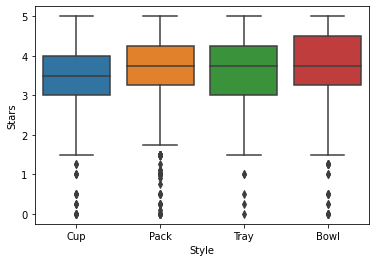

<IPython.core.display.Javascript object>

In [11]:
sns.boxplot(x="Style", y="Stars", data=df)
plt.show()

* Considering ANOVA (independent groups being assumed)
* Check ANOVA assumptions

In [12]:
cup = df[df["Style"] == "Cup"]
pack = df[df["Style"] == "Pack"]
tray = df[df["Style"] == "Tray"]
bowl = df[df["Style"] == "Bowl"]

<IPython.core.display.Javascript object>

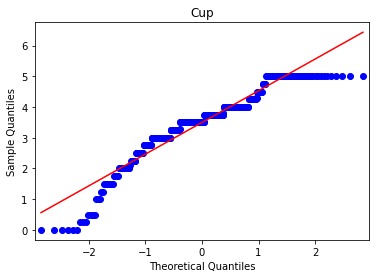

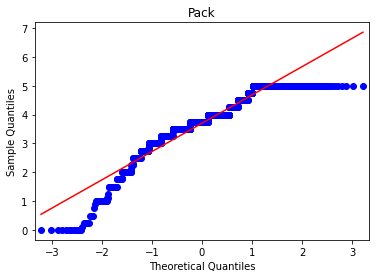

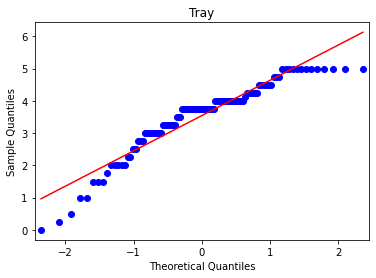

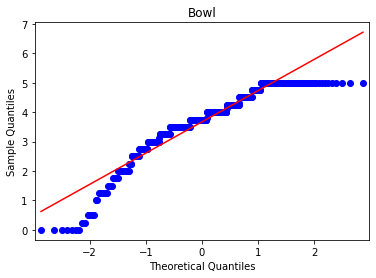

<IPython.core.display.Javascript object>

In [13]:
for style in [cup, pack, tray, bowl]:
    style_name = style["Style"].iloc[0]

    sm.qqplot(style["Stars"], line="s")
    plt.title(style_name)
    plt.show()

* Not feeling great about the normality assumption (ANOVA is robust, but lets move forward with a non-parametric test: Kruskal Wallis)

In [14]:
_, p = stats.kruskal(cup["Stars"], pack["Stars"], tray["Stars"], bowl["Stars"])
p

0.0003115023977099646

<IPython.core.display.Javascript object>

In [15]:
p < 0.05

True

<IPython.core.display.Javascript object>

* We see at least one group who's median is different; lets follow-up with a kruskal wallis and be sure to correct alpha for multiple testing

In [16]:
# consider looking into itertools combinations
# n Choose k
# 4 Choose 2 = 6

<IPython.core.display.Javascript object>

In [17]:
_, p_cp = stats.kruskal(cup["Stars"], pack["Stars"])
_, p_ct = stats.kruskal(cup["Stars"], tray["Stars"])
_, p_cb = stats.kruskal(cup["Stars"], bowl["Stars"])

_, p_pt = stats.kruskal(pack["Stars"], tray["Stars"])
_, p_pb = stats.kruskal(pack["Stars"], bowl["Stars"])

_, p_tb = stats.kruskal(tray["Stars"], bowl["Stars"])

<IPython.core.display.Javascript object>

In [18]:
p_vals = [p_cp, p_ct, p_cb, p_pt, p_pb, p_tb]
reject_ho, _, _, _, = multipletests(p_vals)
reject_ho

array([ True, False,  True, False, False, False])

<IPython.core.display.Javascript object>

* Follow-up tests are showing that the following pairs are significantly different:
    * Cup vs Pack
    * Cup vs Bowl

Bootsrapped CI of median diff

In [19]:
def bootstrap_median_diff(x1, x2, n=10000):
    median_diffs = []
    for i in range(n):
        s1 = x1.sample(frac=1.0, replace=True)
        s2 = x2.sample(frac=1.0, replace=True)

        median_diff = s1.median() - s2.median()
        median_diffs.append(median_diff)

    return median_diffs

<IPython.core.display.Javascript object>

In [20]:
diffs_cp = bootstrap_median_diff(cup["Stars"], pack["Stars"])
diffs_cb = bootstrap_median_diff(cup["Stars"], bowl["Stars"])

<IPython.core.display.Javascript object>

In [21]:
ci_lo_cp = np.percentile(diffs_cp, 2.5)
ci_hi_cp = np.percentile(diffs_cp, 97.5)
ci_lo_cb = np.percentile(diffs_cb, 2.5)
ci_hi_cb = np.percentile(diffs_cb, 97.5)

<IPython.core.display.Javascript object>

In [22]:
ci_lo_cp, ci_hi_cp

(-0.25, 0.0)

<IPython.core.display.Javascript object>

In [23]:
ci_lo_cb, ci_hi_cb

(-0.5, 0.0)

<IPython.core.display.Javascript object>

* Packs score about 0 to a 0.25 stars higher than cups.
* Bowls score about 0 to a 0.5 stars higher than cups.

Common language effect size

In [24]:
# If we were to choose a random rating from each style
# we'd expect the pack rating to be higher 51.4% of the time.
cles_ind(cup["Stars"], pack["Stars"])

0.514368819080861

<IPython.core.display.Javascript object>

In [25]:
# If we were to choose a random rating from each style
# we'd expect the bowl rating to be higher 51.6% of the time.
cles_ind(cup["Stars"], bowl["Stars"])

0.515902055902056

<IPython.core.display.Javascript object>